# Hybrid flow shop

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://githubtocolab.com/PyJobShop/PyJobShop/blob/main/examples/hybrid_flow_shop.ipynb)

> If you're using this notebook in Google Colab, be sure to install PyJobShop first by executing ```pip install pyjobshop``` in a cell.

The hybrid flow shop (HFS) is a common manufacturing environment in practice and widely studied by scheduling researchers. See for example the surveys by [Ruiz and Vázquez-Rodríguez (2010)](https://www.sciencedirect.com/science/article/pii/S0377221709006390) and [Ribas et al. (2010)](https://www.sciencedirect.com/science/article/pii/S0305054809002883) for an overview of HFS studies.

In this notebook, we demonstrate how to model and solve a HFS problem using PyJobShop.

## Problem description
The HFS problem is characterized as follows:

- There is a set of $n$ jobs that need to be processed in a series of stages.
- The number of processing stages is at least 2.
- Each stage has at least one machine in parallel, and in at least one stage there is more than one machine.
- All jobs are processed in the same production order: production starts in stage 1, then stage 2, etc. until the last stage. A job can only start processing when it has finished processing in the previous stage.

The figure below illustrates a small HFS example with three jobs and three stages. The first and third stage have three machines, and the second stage has two machines.

![HFS](../assets/hybrid-flow-shop.png "HFS")

We can model an HFS problem using PyJobShop. For each job and each stage $k$, define one task. Moreover, we need to ensure that the previous task (job in stage $k-1$) is processed before, which known as a precedence constraint.

Let's now implement the above example using PyJobShop's Model interface.

## Model

In [1]:
num_jobs = 10
num_stages = 3
num_machines = [3, 2, 3]

In [2]:
import random

random.seed(42)

PROCESSING_TIMES = {
    (job, stage): random.randint(5, 20)
    for job in range(num_jobs)
    for stage in range(num_stages)
}

The following will be helpful to plot names with $\LaTeX$ typesetting.

In [3]:
def machine_name(machine, stage):
    return f"$M_{{{machine}{stage}}}$"


def job_name(job: int, stage: int):
    return f"$J_{{{job}{stage}}}$"

In [4]:
from pyjobshop import Model

model = Model()

First define the machine layout:

In [5]:
stage2machines = {}
for k in range(num_stages):
    stage2machines[k] = [
        model.add_machine(name=machine_name(m, k))
        for m in range(num_machines[k])
    ]

Now, we need to define jobs and the tasks that have to be scheduled, along with the processing time data and precedence constraints, as mentioned earlier.

In [6]:
jobs = [model.add_job() for _ in range(num_jobs)]

for j, job in enumerate(jobs):
    tasks = [
        model.add_task(job=job, name=job_name(j, k)) for k in range(num_stages)
    ]

    for stage in range(num_stages):
        for machine in stage2machines[stage]:
            duration = PROCESSING_TIMES[j, stage]
            model.add_processing_time(tasks[stage], machine, duration)

    for idx in range(num_stages - 1):
        first = tasks[idx]
        second = tasks[idx + 1]
        model.add_end_before_start(first, second)

In [7]:
result = model.solve(display=False)

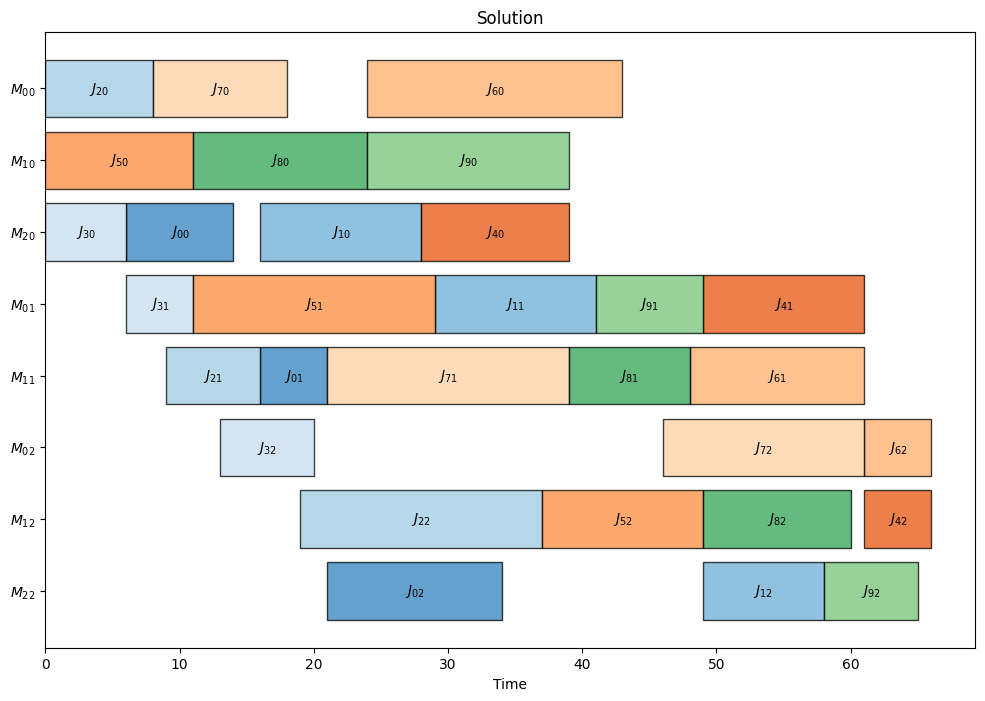

In [8]:
from pyjobshop import plot

data = model.data()
plot(data, result.best, plot_labels=True)

## No-wait

In [9]:
model = Model()

stage2machines = {}
for k in range(num_stages):
    stage2machines[k] = [
        model.add_machine(name=machine_name(m, k))
        for m in range(num_machines[k])
    ]

jobs = [model.add_job() for _ in range(num_jobs)]

for j, job in enumerate(jobs):
    tasks = [
        model.add_task(job=job, name=job_name(j, k)) for k in range(num_stages)
    ]

    for stage in range(num_stages):
        for machine in stage2machines[stage]:
            duration = PROCESSING_TIMES[j, stage]
            model.add_processing_time(tasks[stage], machine, duration)

    for idx in range(num_stages - 1):
        first = tasks[idx]
        second = tasks[idx + 1]
        model.add_end_at_start(first, second)

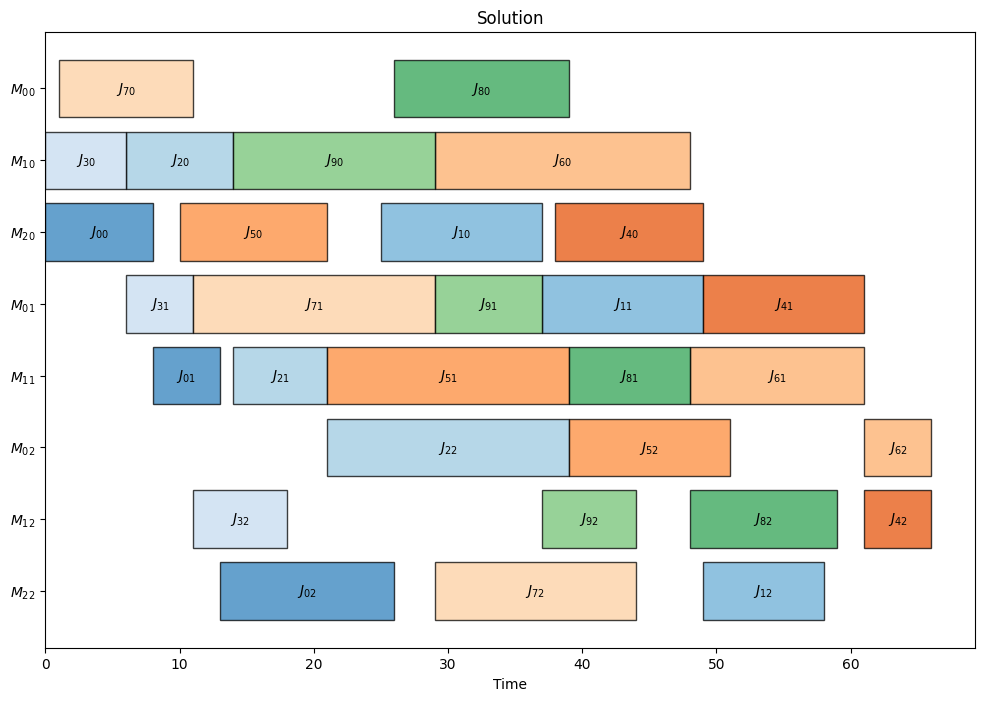

In [10]:
result = model.solve(display=False)

data = model.data()
plot(data, result.best, plot_labels=True)

## Blocking

What if we want to have blocking? We can do that by keeping the same constraints, but set the `fixed_duration` to `False` for the task. By default, all tasks have a fixed duration (determined by their processing mode), but in blocking flow shops we can have tasks with variable durations as they depend on whether the machine is blocking or not.

In [11]:
model = Model()

stage2machines = {}
for k in range(num_stages):
    stage2machines[k] = [
        model.add_machine(name=machine_name(m, k))
        for m in range(num_machines[k])
    ]

jobs = [model.add_job() for _ in range(num_jobs)]

for j, job in enumerate(jobs):
    tasks = [
        model.add_task(job=job, fixed_duration=False, name=job_name(j, k))
        for k in range(num_stages)
    ]

    for stage in range(num_stages):
        for machine in stage2machines[stage]:
            duration = PROCESSING_TIMES[j, stage]
            model.add_processing_time(tasks[stage], machine, duration)

    for idx in range(num_stages - 1):
        first = tasks[idx]
        second = tasks[idx + 1]
        model.add_end_before_start(first, second)

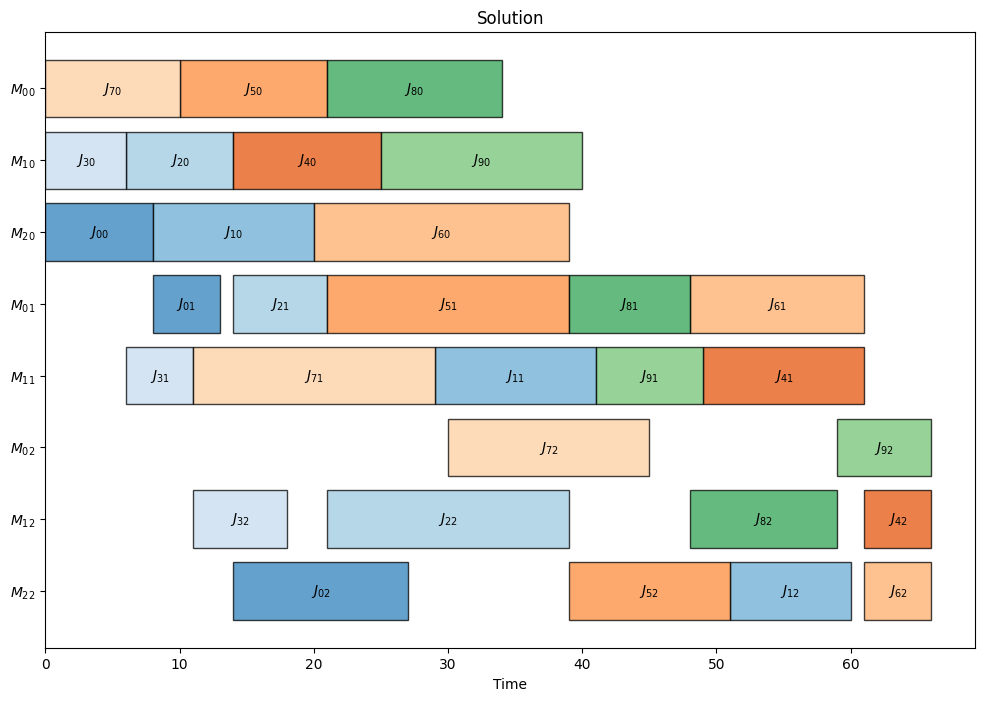

In [12]:
result = model.solve(display=False)

data = model.data()
plot(data, result.best, plot_labels=True)

## Conclusion
This notebooks showed how to model and solve the hybrid flow shop problem using PyJobShop. Specifically, we show how to define the hybrid flow shop problem in terms of tasks and how to add precedence constraints between tasks.
- Blocking
- No wait